In [1]:
import matplotlib
matplotlib.use('Agg')

# Get setup

% matplotlib inline 
#plots in the doc

# homebrewed modules
from metro import io            # for reading multiplex
from metro import utility       # for manipulating multiplex
from metro import analysis      # analytical functions
from metro import viz           # for bubble_plot()
from metro import assignment    # for reading and manipulating OD data

# other modules
import warnings                 # suppress ipython warnings
import networkx as nx           # assigning attributes to multiplex
import matplotlib.pyplot as plt # convenience for plotting
import seaborn as sns           # main plotting library
from matplotlib import pylab    # for colormap manipulation
import numpy as np              # math functions
import pandas as pd

# preferences across the worksheet
warnings.filterwarnings('ignore') # stops ipython from printing warnings
sns.set_style("white") # nicer background style


/home/pchodrow/.local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
multi = io.read_multi() # read the prepared multiplex from 2_multiplex/

In [3]:
# add the congestion gradient to each segment under preexisting assignment (see assign_traffic.py)
gradient = {(e[0],e[1]) : analysis.congestion_gradient(multi.G.edge[e[0]][e[1]]['free_flow_time_m'],
                                                       multi.G.edge[e[0]][e[1]]['flow'],
                                                       multi.G.edge[e[0]][e[1]]['capacity']) for e in multi.G.edges_iter()}

nx.set_edge_attributes(multi.G, 'gradient', gradient)

### Metro paths

The purpose of this section is to compute the shortest paths between all metro layers. The output should be a dict keyed by metro pairs with an edge sequence between them as values. 


In [4]:
metro = utility.nx_2_igraph(multi.layers_as_subgraph(['metro']))
                            
def get_metro_paths(g,v):
    paths = g.get_shortest_paths(v = v,
                                to = metro.vs, 
                                weights = 'congested_time_m',
                                mode = 'OUT',
                                output = 'vpath')
    
    paths = {metro.vs[i]['name'] : [metro.vs[u]['name'] for u in paths[i]] for i in range(len(paths))}  
    return paths

d = {v['name'] : get_metro_paths(metro,v) for v in metro.vs}

The purpose of this section is to compute the shortest paths between each taz and its nearest metro stop. 

In [5]:
def grad_to_metro(multi):
    def route_gradient(u,v,g):
        path = g.get_shortest_paths(u,v,weights='congested_time_m',output='epath')[0]
        gradient = sum([g.es[e]['gradient'] for e in path])
        return gradient

    def rowwise_gradient(row):
        return route_gradient(row['taz'], row['closest_metro'], g)

    G = multi.layers_as_subgraph(['metro', 'taz', 'streets'])
    g = utility.nx_2_igraph(G)

    taz_nodes = g.vs.select(lambda v : v['layer'] == 'taz')
    metro_nodes = g.vs.select(lambda v : v['layer'] == 'metro')

    x = g.shortest_paths_dijkstra(source = taz_nodes, target = metro_nodes, weights = 'congested_time_m') 
    x = np.array(x)
    nearest = np.argmin(x, axis=1)
    
    taz_nodes = [taz_nodes[i].index for i in range(len(taz_nodes))]
    closest_metro = [metro_nodes[nearest[i]].index for i in range(len(taz_nodes))]
    dg = pd.DataFrame({'taz' : taz_nodes, 'closest_metro' : closest_metro})
    dg['gradient'] = dg.apply(rowwise_gradient, axis = 1)

    node_lookup = {v.index : v['name'] for v in g.vs}
    dg['closest_metro'] = dg['closest_metro'].map(node_lookup.get)
    dg['taz'] = dg['taz'].map(node_lookup.get)
    
    return dg

In [6]:
to_metro = grad_to_metro(multi)
metro_gradient = to_metro[['taz','gradient']].set_index('taz').T.to_dict('records')[0]

In [9]:
def street_gradients(multi):
    def compute_gradients(sources, targets, graph):
        o = []
        d = []
        gradient = []
        for v in sources:
            paths = graph.get_shortest_paths(v, to = targets,weights = 'congested_time_m', output = 'epath')
            for i in range(len(targets)):
                grad = sum([graph.es[e]['gradient'] for e in paths[i]])
                o.append(v.index)
                d.append(targets[i].index)
                gradient.append(grad)
        df = pd.DataFrame({'o' : o, 'd' : d, 'gradient' : gradient})
        return df[['o','d','gradient']]
    
    g = utility.nx_2_igraph(multi.layers_as_subgraph(['taz','streets']))
    taz_nodes = g.vs.select(lambda v : v['layer'] == 'taz')
    
    df = compute_gradients(taz_nodes, taz_nodes, g)
    
    node_lookup = node_lookup = {v.index : v['name'] for v in g.vs}
    df['o'] = df['o'].map(node_lookup.get)
    df['d'] = df['d'].map(node_lookup.get)
    
    return df

In [10]:
street_grad = street_gradients(multi)

In [11]:
# keys are wrong, since metro_gradient is keyed on a graph that includes the metro. need to convert to nx keys
street_grad['o_metro_gradient'] = street_grad.o.map(metro_gradient.get)
street_grad['d_metro_gradient'] = street_grad.d.map(metro_gradient.get)
street_grad['net_gradient'] = street_grad['gradient'] - street_grad['o_metro_gradient'] - street_grad['d_metro_gradient']
street_grad = street_grad.sort_values('net_gradient', ascending = False)

,o,d,gradient,o_metro_gradient,d_metro_gradient,net_gradient
10174207,taz_14728,taz_5455,78.457216,0.873829,3.354246,74.229141
10173012,taz_14728,taz_450,78.173353,0.873829,3.274425,74.025100
10171887,taz_14728,taz_10428,75.002599,0.873829,0.207026,73.921744
10174269,taz_14728,taz_1602,78.439925,0.873829,3.710699,73.855397
10173917,taz_14728,taz_8321,77.675844,0.873829,3.035911,73.766103


In [19]:
od = assignment.od_dict(multi.G, '1_data/taz_od/0_1.txt', pivot = False)
street_grad = street_grad.merge(od)

In [21]:
street_grad['impact'] = street_grad['flow_norm'] * street_grad['gradient']
street_grad['net_impact'] = street_grad['flow_norm'] * street_grad['net_gradient']

In [22]:
street_grad.describe()

,gradient,o_metro_gradient,d_metro_gradient,net_gradient,flow_norm,impact,net_impact
count,4676917.000000,4676917.000000,4676917.000000,4676917.000000,4676917.000000,4676917.000000,4676917.000000
mean,9.220023,1.069935,1.081589,7.068499,0.501044,3.493139,1.950768
std,9.608787,2.970363,2.928935,9.411643,3.059608,34.753337,81.478258
min,0.000000,0.000000,0.000000,-132.470374,0.000000,0.000000,-62958.283919
25%,2.520845,0.014973,0.014874,0.868723,0.036667,0.136373,0.022539
50%,6.345075,0.262367,0.277311,4.501782,0.116667,0.598500,0.333181
75%,12.755733,1.160546,1.191255,10.815179,0.355556,2.221682,1.558371
max,123.232609,66.235187,66.235187,74.229141,1331.312500,16094.453399,4344.017860


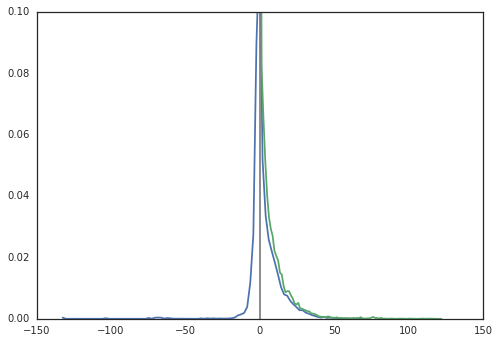

In [87]:
n = 100
hist = np.histogram(street_grad['net_gradient'], weights = street_grad['flow_norm'], normed = True, bins = n)
x = hist[1][:n] 
y = hist[0]
plt.plot(x,y)

hist = np.histogram(street_grad['gradient'], weights = street_grad['flow_norm'], normed = True, bins = n)
x = hist[1][:n] 
y = hist[0]
plt.plot(x,y)
plt.gca().set(ylim = (0,.1))
plt.plot((0,0),(0,1), color = 'grey')


[(0, 1), (-10, 60)]

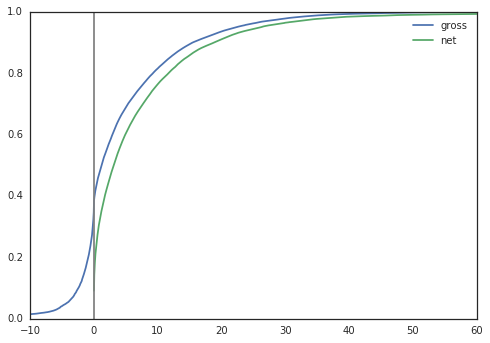

In [107]:
n = 10000
hist = np.histogram(street_grad['net_gradient'], weights = street_grad['flow_norm'], normed = True, bins = n)
x = hist[1][:n] 
y = hist[0]
plt.plot(x,(y*(x[1] - x[0])).cumsum(), label = 'gross')

hist = np.histogram(street_grad['gradient'], weights = street_grad['flow_norm'], normed = True, bins = n)
x = hist[1][:n] 
y = hist[0]
plt.plot(x,(y*(x[1] - x[0])).cumsum(), label = 'net')
plt.plot((0,0),(0,1), color = 'grey')
plt.legend()
plt.gca().set(xlim = (-10,60), ylim = (0,1))

How to read: roughly 37% of people would actually cause MORE congestion by driving to metro stations, the remaining would see some improvement. An adoption plan would want to target those in the positive tail who could see substantial positive impact; there are roughly 10% who would reduce congestion experienced by 20 mins or more by driving to public transit. 